# Bag of Words Text Classification

In this tutorial we will show how to build a simple Bag of Words (BoW) text classifier using PyTorch. The classifier is trained on IMDB movie reviews dataset.

This notebook is adapted from https://github.com/scoutbee/pytorch-nlp-notebooks/blob/develop/1_BoW_text_classification.ipynb


## Concepts covered in this tutorial
1. NLP text pre-processing
2. Split of training, validation and testing datasets
3. How to build a simple linear classifier using PyTorch
4. Training the model and the balance of Under-fitting v.s. Over-fitting
5. BoW and TF-IDF text classifier

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
import random
import re # regular expression
from collections import Counter
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google_drive_downloader import GoogleDriveDownloader as gdd
from IPython.core.display import display, HTML
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF
from sklearn.metrics import classification_report
from tqdm import tqdm, tqdm_notebook # show progress bar

# PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

# nltk text processors
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
plt.style.use('ggplot')
tqdm.pandas()
print("torch.get_default_device()",torch.get_default_device())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)
print("torch.get_default_device()",torch.get_default_device())

torch.get_default_device() cpu
torch.get_default_device() cpu


In [3]:
DATA_PATH = 'data/imdb_reviews.csv'
if not Path(DATA_PATH).is_file():
    gdd.download_file_from_google_drive(
        file_id='1zfM5E6HvKIe7f3rEt1V2gBpw5QOSSKQz',
        dest_path=DATA_PATH,
    )

**Take a look at a few examples**

In [4]:
df = pd.read_csv(DATA_PATH)
df.sample(5)

,review,label
12376,I saw this film at the Rotterdam International...,1
37740,"A light-hearted comedy, Nothing shows us a wor...",1
4024,Talk about marketing. The poster/home video co...,0
31180,The film gives a rather condensed version of w...,0
26418,"Definitely not worth the rental, but if you ca...",0


In [5]:
print('Number of records:', len(df), '\n')
print('Number of positive reviews:', len(df[df.label == 1]))
print('Number of negative reviews:', len(df[df.label == 0]), '\n')

print('Example negative review:')
print(df.loc[55,].review, '\n')
print('Example positive review:')
print(df.loc[12361,].review, '\n')

Number of records: 62155 

Number of positive reviews: 30870
Number of negative reviews: 31285 

Example negative review:
Seeing this film for the first time twenty years after its release I don't quite get it. Why has this been such a huge hit in 1986? Its amateurishness drips from every scene. The jokes are lame and predictable. The sex scenes are exploitative and over the top (that is not to say that Miss Rudnik does not have nice boobs!). The singing is "schrecklich". The only genuinely funny scene is the big shoot out when the gangsters die break dancing, a trait that dates the movie firmly to the mid-eighties. It's really quite puzzling to me how incapable I am to grasp what evoked the enthusiasm of the cheering audiences in 1986 (and apparently still today, reading my fellow IMDBers comments). 

Example positive review:
I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton

## Preprocess Text

* Replace weird characters
* Lowercase
* Tokenize
* Stemming & Lemmatize
* Remove stopwords

**Let's see how to pre-process these steps one by one. Below I constructed a test corpus which composed of 3 reviews. Each review is a paragraph.**

In [6]:
test_corpus = '''The Intel Core i5 processor that comes with the Dell Latitude 5490 is quad-core and offers 1.6GHz and a 6M cache. The base configuration includes 1 x 4GB of DDR4 Non-CC memory, but this can be upgraded to 8GB or even 16GB (2 x 8GB) if you require more memory. How great is that!?
The 14-inch display is available with your choice of 1366 x 768 or 1920 x 1080 resolution. Both versions are non-touch, WLAN capable, and come with anti-glare technology. You also get a built-in camera and microphone. For wireless technology, the system comes with a Qualcomm QCA61 x 4A 802.11 ac (2×2) wireless adapter+.
'''
test_corpus

'The Intel Core i5 processor that comes with the Dell Latitude 5490 is quad-core and offers 1.6GHz and a 6M cache. The base configuration includes 1 x 4GB of DDR4 Non-CC memory, but this can be upgraded to 8GB or even 16GB (2 x 8GB) if you require more memory. How great is that!?\nThe 14-inch display is available with your choice of 1366 x 768 or 1920 x 1080 resolution. Both versions are non-touch, WLAN capable, and come with anti-glare technology. You also get a built-in camera and microphone. For wireless technology, the system comes with a Qualcomm QCA61 x 4A 802.11 ac (2×2) wireless adapter+.\n'

In [7]:
# remove special characters & lowercase
clean_corpus = re.sub(r'[^\w\s]', '', test_corpus)
clean_corpus = clean_corpus.lower()
clean_corpus

'the intel core i5 processor that comes with the dell latitude 5490 is quadcore and offers 16ghz and a 6m cache the base configuration includes 1 x 4gb of ddr4 noncc memory but this can be upgraded to 8gb or even 16gb 2 x 8gb if you require more memory how great is that\nthe 14inch display is available with your choice of 1366 x 768 or 1920 x 1080 resolution both versions are nontouch wlan capable and come with antiglare technology you also get a builtin camera and microphone for wireless technology the system comes with a qualcomm qca61 x 4a 80211 ac 22 wireless adapter\n'

In [8]:
# tokenize
clean_tokens = wordpunct_tokenize(clean_corpus)
print(clean_tokens)

['the', 'intel', 'core', 'i5', 'processor', 'that', 'comes', 'with', 'the', 'dell', 'latitude', '5490', 'is', 'quadcore', 'and', 'offers', '16ghz', 'and', 'a', '6m', 'cache', 'the', 'base', 'configuration', 'includes', '1', 'x', '4gb', 'of', 'ddr4', 'noncc', 'memory', 'but', 'this', 'can', 'be', 'upgraded', 'to', '8gb', 'or', 'even', '16gb', '2', 'x', '8gb', 'if', 'you', 'require', 'more', 'memory', 'how', 'great', 'is', 'that', 'the', '14inch', 'display', 'is', 'available', 'with', 'your', 'choice', 'of', '1366', 'x', '768', 'or', '1920', 'x', '1080', 'resolution', 'both', 'versions', 'are', 'nontouch', 'wlan', 'capable', 'and', 'come', 'with', 'antiglare', 'technology', 'you', 'also', 'get', 'a', 'builtin', 'camera', 'and', 'microphone', 'for', 'wireless', 'technology', 'the', 'system', 'comes', 'with', 'a', 'qualcomm', 'qca61', 'x', '4a', '80211', 'ac', '22', 'wireless', 'adapter']


In [9]:
lemmatizer = WordNetLemmatizer()
clean_tokens = [lemmatizer.lemmatize(token) for token in clean_tokens]
clean_tokens = [lemmatizer.lemmatize(token, "v") for token in clean_tokens]
print(clean_tokens)

['the', 'intel', 'core', 'i5', 'processor', 'that', 'come', 'with', 'the', 'dell', 'latitude', '5490', 'be', 'quadcore', 'and', 'offer', '16ghz', 'and', 'a', '6m', 'cache', 'the', 'base', 'configuration', 'include', '1', 'x', '4gb', 'of', 'ddr4', 'noncc', 'memory', 'but', 'this', 'can', 'be', 'upgrade', 'to', '8gb', 'or', 'even', '16gb', '2', 'x', '8gb', 'if', 'you', 'require', 'more', 'memory', 'how', 'great', 'be', 'that', 'the', '14inch', 'display', 'be', 'available', 'with', 'your', 'choice', 'of', '1366', 'x', '768', 'or', '1920', 'x', '1080', 'resolution', 'both', 'version', 'be', 'nontouch', 'wlan', 'capable', 'and', 'come', 'with', 'antiglare', 'technology', 'you', 'also', 'get', 'a', 'builtin', 'camera', 'and', 'microphone', 'for', 'wireless', 'technology', 'the', 'system', 'come', 'with', 'a', 'qualcomm', 'qca61', 'x', '4a', '80211', 'ac', '22', 'wireless', 'adapter']


In [10]:
clean_tokens = [re.sub(r'\b[0-9]+\b', '<NUM>', token) for token in clean_tokens]
print(clean_tokens)

['the', 'intel', 'core', 'i5', 'processor', 'that', 'come', 'with', 'the', 'dell', 'latitude', '<NUM>', 'be', 'quadcore', 'and', 'offer', '16ghz', 'and', 'a', '6m', 'cache', 'the', 'base', 'configuration', 'include', '<NUM>', 'x', '4gb', 'of', 'ddr4', 'noncc', 'memory', 'but', 'this', 'can', 'be', 'upgrade', 'to', '8gb', 'or', 'even', '16gb', '<NUM>', 'x', '8gb', 'if', 'you', 'require', 'more', 'memory', 'how', 'great', 'be', 'that', 'the', '14inch', 'display', 'be', 'available', 'with', 'your', 'choice', 'of', '<NUM>', 'x', '<NUM>', 'or', '<NUM>', 'x', '<NUM>', 'resolution', 'both', 'version', 'be', 'nontouch', 'wlan', 'capable', 'and', 'come', 'with', 'antiglare', 'technology', 'you', 'also', 'get', 'a', 'builtin', 'camera', 'and', 'microphone', 'for', 'wireless', 'technology', 'the', 'system', 'come', 'with', 'a', 'qualcomm', 'qca61', 'x', '4a', '<NUM>', 'ac', '<NUM>', 'wireless', 'adapter']


In [11]:
stop_words = set(stopwords.words('english'))
clean_tokens = [token for token in clean_tokens if token not in stop_words]
print(clean_tokens)

['intel', 'core', 'i5', 'processor', 'come', 'dell', 'latitude', '<NUM>', 'quadcore', 'offer', '16ghz', '6m', 'cache', 'base', 'configuration', 'include', '<NUM>', 'x', '4gb', 'ddr4', 'noncc', 'memory', 'upgrade', '8gb', 'even', '16gb', '<NUM>', 'x', '8gb', 'require', 'memory', 'great', '14inch', 'display', 'available', 'choice', '<NUM>', 'x', '<NUM>', '<NUM>', 'x', '<NUM>', 'resolution', 'version', 'nontouch', 'wlan', 'capable', 'come', 'antiglare', 'technology', 'also', 'get', 'builtin', 'camera', 'microphone', 'wireless', 'technology', 'system', 'come', 'qualcomm', 'qca61', 'x', '4a', '<NUM>', 'ac', '<NUM>', 'wireless', 'adapter']


In [12]:
def build_vocab(corpus):
    vocab = {}
    for doc in corpus:
        for token in doc:
            if token not in vocab.keys():
                vocab[token] = len(vocab)
    return vocab

print(build_vocab([clean_tokens]))

{'intel': 0, 'core': 1, 'i5': 2, 'processor': 3, 'come': 4, 'dell': 5, 'latitude': 6, '<NUM>': 7, 'quadcore': 8, 'offer': 9, '16ghz': 10, '6m': 11, 'cache': 12, 'base': 13, 'configuration': 14, 'include': 15, 'x': 16, '4gb': 17, 'ddr4': 18, 'noncc': 19, 'memory': 20, 'upgrade': 21, '8gb': 22, 'even': 23, '16gb': 24, 'require': 25, 'great': 26, '14inch': 27, 'display': 28, 'available': 29, 'choice': 30, 'resolution': 31, 'version': 32, 'nontouch': 33, 'wlan': 34, 'capable': 35, 'antiglare': 36, 'technology': 37, 'also': 38, 'get': 39, 'builtin': 40, 'camera': 41, 'microphone': 42, 'wireless': 43, 'system': 44, 'qualcomm': 45, 'qca61': 46, '4a': 47, 'ac': 48, 'adapter': 49}


In [13]:
def build_index2token(vocab):
    index2token = {}
    for token in vocab.keys():
        index2token[vocab[token]] = token
    return index2token

print(build_index2token(build_vocab([clean_tokens])))

{0: 'intel', 1: 'core', 2: 'i5', 3: 'processor', 4: 'come', 5: 'dell', 6: 'latitude', 7: '<NUM>', 8: 'quadcore', 9: 'offer', 10: '16ghz', 11: '6m', 12: 'cache', 13: 'base', 14: 'configuration', 15: 'include', 16: 'x', 17: '4gb', 18: 'ddr4', 19: 'noncc', 20: 'memory', 21: 'upgrade', 22: '8gb', 23: 'even', 24: '16gb', 25: 'require', 26: 'great', 27: '14inch', 28: 'display', 29: 'available', 30: 'choice', 31: 'resolution', 32: 'version', 33: 'nontouch', 34: 'wlan', 35: 'capable', 36: 'antiglare', 37: 'technology', 38: 'also', 39: 'get', 40: 'builtin', 41: 'camera', 42: 'microphone', 43: 'wireless', 44: 'system', 45: 'qualcomm', 46: 'qca61', 47: '4a', 48: 'ac', 49: 'adapter'}


**Bag of Words**



**TF-IDF**



**Let's pacakage the pre-processing steps together into functions and apply on our dataset**

In [14]:
def remove_rare_words(tokens, common_tokens, max_len):
    return [token if token in common_tokens else '<UNK>' for token in tokens][-max_len:]

def replace_numbers(tokens):
    return [re.sub(r'[0-9]+', '<NUM>', token) for token in tokens]

def tokenize(text, stop_words, lemmatizer):
    text = re.sub(r'[^\w\s]', '', text) # remove special characters
    text = text.lower() # lowercase
    tokens = wordpunct_tokenize(text) # tokenize
    tokens = [lemmatizer.lemmatize(token) for token in tokens] # noun lemmatizer
    tokens = [lemmatizer.lemmatize(token, "v") for token in tokens] # verb lemmatizer
    tokens = [token for token in tokens if token not in stop_words] # remove stopwords
    return tokens

def build_bow_vector(sequence, idx2token):
    vector = [0] * len(idx2token)
    for token_idx in sequence:
        if token_idx not in idx2token:
            raise ValueError('Wrong sequence index found!')
        else:
            vector[token_idx] += 1
    return vector

In [15]:
# Set parameters

MAX_LEN = 128 #@param [64, 256, 512, 1024] {allow-input: true}
MAX_VOCAB = 1000 #@param [1000, 5000, 10000, 100000] {allow-input: true}

In [16]:
class ImdbDataset(Dataset):
    def __init__(self, data_path, max_vocab=5000, max_len=128):
        df = pd.read_csv(data_path)

        # Clean and tokenize
        stop_words = set(stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()
        df['tokens'] = df.review.apply(
            partial(
                tokenize,
                stop_words=stop_words,
                lemmatizer=lemmatizer,
            ),
        )

        all_tokens = [token for doc in list(df.tokens) for token in doc]

        # Build most common tokens bound by max vocab size
        common_tokens = set(
            list(
                zip(*Counter(all_tokens).most_common(max_vocab))
            )[0]
        )

        # Replace rare words with <UNK>
        df.loc[:, 'tokens'] = df.tokens.progress_apply(
            partial(
                remove_rare_words,
                common_tokens=common_tokens,
                max_len=max_len,
            ),
        )

        # Replace numbers with <NUM>
        df.loc[:, 'tokens'] = df.tokens.progress_apply(replace_numbers)

        # Remove sequences with only <UNK>
        df = df[df.tokens.progress_apply(
            lambda tokens: any(token != '<UNK>' for token in tokens),
        )]

        # Build vocab
        vocab = sorted(set(
            token for doc in list(df.tokens) for token in doc
        ))
        self.token2idx = {token: idx for idx, token in enumerate(vocab)}
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}

        # Convert tokens to indexes
        df['indexed_tokens'] = df.tokens.progress_apply(
            lambda doc: [self.token2idx[token] for token in doc],
        )

        # Build BoW vector
        df['bow_vector'] = df.indexed_tokens.progress_apply(
            build_bow_vector, args=(self.idx2token,)
        )

        # Build TF-IDF vector
        vectorizer = TfidfVectorizer(
            analyzer='word',
            tokenizer=lambda doc: doc,
            preprocessor=lambda doc: doc,
            token_pattern=None,
        )
        vectors = vectorizer.fit_transform(df.tokens).toarray()
        df['tfidf_vector'] = [vector.tolist() for vector in vectors]

        self.text = df.review.tolist()
        self.sequences = df.indexed_tokens.tolist()
        self.bow_vector = df.bow_vector.tolist()
        self.tfidf_vector = df.tfidf_vector.tolist()
        self.targets = df.label.tolist()

    def __getitem__(self, i):
        return (
            self.sequences[i],
            self.bow_vector[i],
            self.tfidf_vector[i],
            self.targets[i],
            self.text[i],
        )

    def __len__(self):
        return len(self.targets)

In [17]:
dataset = ImdbDataset(DATA_PATH, max_vocab=MAX_VOCAB, max_len=MAX_LEN)

100%|██████████| 62154/62154 [00:02<00:00, 22307.37it/s]


See a random sample out of the dataset processed

In [18]:
print('Number of records:', len(dataset), '\n')

import random
random_idx = random.randint(0,len(dataset)-1)
print('index:', random_idx, '\n')
sample_seq, bow_vector, tfidf_vector, sample_target, sample_text = dataset[random_idx]
print(sample_text, '\n')
print(sample_seq, '\n')
print('BoW vector size:', len(bow_vector), '\n')
print('BoW vector first 10:', bow_vector[:10], '\n')
print('TF-IDF vector size:', len(tfidf_vector), '\n')
print('TF-IDF vector first 10:', tfidf_vector[:10], '\n')
print('Sentiment:', sample_target, '\n')

Number of records: 62154 

index: 56446 

\Shall We Dance?\", a light-hearted flick from Japan, tells of an overworked accountant and family man who is attracted to a dance studio by a beautiful woman he see's from the train during his daily commute. What he finds in the studio are lessons in dancing and, most of all, himself. Funny, poignant, and utterly charming, \"SWD\" is an award winning film well worth a look by more mature viewers. (B)" 

[1, 206, 1, 352, 1, 861, 1, 1, 321, 524, 1, 206, 830, 82, 963, 749, 892, 1, 1, 343, 830, 1, 206, 369, 1, 1, 144, 1, 66, 958, 338, 948, 973, 513, 1, 927, 69] 

BoW vector size: 990 

BoW vector first 10: [0, 13, 0, 0, 0, 0, 0, 0, 0, 0] 

TF-IDF vector size: 990 

TF-IDF vector first 10: [0.0, 0.48471888732306145, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 

Sentiment: 1 



## Split into training, validation, and test sets

- **Training**: data the model learns from
- **Validation**: data to evaluate with for hyperparameter tuning (make sure the model doesn't overfit!)
- **Testing**: data to evaluate the final performance of the model

In [19]:
def split_train_valid_test(corpus, valid_ratio=0.1, test_ratio=0.1):
    """Split dataset into train, validation, and test."""
    test_length = int(len(corpus) * test_ratio)
    valid_length = int(len(corpus) * valid_ratio)
    train_length = len(corpus) - valid_length - test_length
    generator = torch.Generator(device=device).manual_seed(42) # Create a generator with a fixed seed for reproducibility
    return random_split(
        corpus, lengths=[train_length, valid_length, test_length], generator=generator
    )

In [20]:
train_dataset, valid_dataset, test_dataset = split_train_valid_test(
    dataset, valid_ratio=0.05, test_ratio=0.05)
len(train_dataset), len(valid_dataset), len(test_dataset)

(55940, 3107, 3107)

In [21]:
BATCH_SIZE = 256

def collate(batch):
    seq = [item[0] for item in batch]
    bow = [item[1] for item in batch]
    tfidf = [item[2] for item in batch]
    target = torch.LongTensor([item[3] for item in batch]).to(device)
    text = [item[4] for item in batch]
    return seq, bow, tfidf, target, text

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate)

In [22]:
print('number of training batches:', len(train_loader), '\n')
batch_idx = random.randint(0, len(train_loader)-1)
example_idx = random.randint(0, BATCH_SIZE-1)

for i, fields in enumerate(train_loader):
    seq, bow, tfidf, target, text = fields
    if i == batch_idx:
        print('Training input sequence:', seq[example_idx], '\n')
        print('BoW vector size:', len(bow[example_idx]), '\n')
        print('TF-IDF vector size:', len(tfidf[example_idx]), '\n')
        print('Label: ', target[example_idx], '\n')
        print('Review text:', text[example_idx], '\n')


number of training batches: 219 

Training input sequence: [157, 1, 338, 131, 756, 520, 143, 378, 1, 742, 879, 642, 311, 143, 1, 338, 354, 1, 143, 1, 599, 394, 1, 911, 1, 368, 369, 85, 279, 394, 304, 164, 387, 566, 89, 749, 561, 387, 601, 622] 

BoW vector size: 990 

TF-IDF vector size: 990 

Label:  tensor(1) 

Review text: This is a classic animated film from the cartoon series! Most of the major characters get alot of screen time plus do extra characters aswell! The film`s focus is on the superstar characters vacation and each one has his/her very unique summer fun! Its very funny from beginning to end! It has excellent color, great music and believe it or not I have seen this more than any movie. Its that great and in MY opinion its perfect! 



## BoW Model

### Build BoW Linear Model

- Input: BoW Vector
- Model:
    - linear mapping of bow vector to logits
- Output:
    - vector size of 2 (2 possible outcome: positive v.s. negative)
    - probability of input document classified as the label

In [23]:
class LinearTextClassifier(nn.Module):
    def __init__(self, vocab_size, num_labels):
        super(LinearTextClassifier, self).__init__()
        self.fc = nn.Linear(vocab_size, num_labels)

    def forward(self, x):
        x = torch.FloatTensor(x).to(device)
        return torch.softmax(self.fc(x),dim=-1)


P.S. You can also add layers or reduce layers by modifying the cell below

In [24]:
bow_model = LinearTextClassifier(
    vocab_size=len(dataset.token2idx),
    num_labels=2,
)
bow_model

LinearTextClassifier(
  (fc): Linear(in_features=990, out_features=2, bias=True)
)

In [25]:
for param in bow_model.parameters():
    print(param.size())

torch.Size([2, 990])
torch.Size([2])


### Train BoW Model




affine scoring: $$logits = \theta X + b$$
output: $$p = softmax(logits)$$
Loss: $$L = −y_0 log(p_0)-y_1 log(p_1)$$
Gradient:
$$\frac{\partial }{\partial \theta}L(\theta, b) = \frac{\partial L}{\partial p}\frac{\partial p}{\partial logits}\frac{\partial logits}{\partial  \theta}$$

Parameter update:
$$ \theta =  \theta - \alpha \frac{\partial }{\partial \theta}L(\theta, b)$$

**Define the initial learning rate**

What happens if you set a very small learning rate? What if you set a very large learning rate?

In [26]:
LEARNING_RATE = 5e-5

**Define loss function and gradient descent optimizer**

- Criterion: compute *Loss* to see how much does prediction differ from truth
- Optimizer: different ways of updating the weight parameters. It can affect the speed of training and how easily are global minimum reached.
- scheduler: dynamic alter the learning rate

When selecting optimizers, you can think about what problems can we run into when performing gradient desent? (hint: global minimum v.s. local minimum)

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, bow_model.parameters()),
    lr=LEARNING_RATE,
)
scheduler = CosineAnnealingLR(optimizer, 1)

**Define training round & validation round**

In [28]:
def train_epoch(model, optimizer, train_loader, input_type='bow'):
    model.train()
    total_loss, total = 0, 0
    for seq, bow, tfidf, target, text in train_loader:
        if input_type == 'bow':
            inputs = bow
        if input_type == 'tfidf':
            inputs = tfidf

        # Reset gradient
        optimizer.zero_grad()

        # Forward pass
        output = model(inputs)

        # Compute loss
        loss = criterion(output, target)

        # Perform gradient descent, backwards pass
        loss.backward()

        # Take a step in the right direction
        optimizer.step()
        scheduler.step()

        # Record metrics
        total_loss += loss.item()
        total += len(target)

    return total_loss / total


def validate_epoch(model, valid_loader, input_type='bow'):
    model.eval()
    total_loss, total = 0, 0
    with torch.no_grad():
        for seq, bow, tfidf, target, text in valid_loader:
            if input_type == 'bow':
                inputs = bow
            if input_type == 'tfidf':
                inputs = tfidf

            # Forward pass
            output = model(inputs)

            # Calculate how wrong the model is
            loss = criterion(output, target)

            # Record metrics
            total_loss += loss.item()
            total += len(target)

    return total_loss / total

** Run training epochs**

In [29]:
n_epochs = 0
train_losses, valid_losses = [], []
while True:
    train_loss = train_epoch(bow_model, optimizer, train_loader, input_type='bow')
    valid_loss = validate_epoch(bow_model, valid_loader, input_type='bow')

    tqdm.write(
        f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.2e}\tvalid_loss: {valid_loss:.2e}\n',
    )

    # Early stopping if the current valid_loss is greater than the last three valid losses
    if len(valid_losses) > 2 and all(valid_loss >= loss for loss in valid_losses[-3:]):
        print('Stopping early')
        break
    if n_epochs>=100:
        break
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    n_epochs += 1

epoch #  1	train_loss: 2.75e-03	valid_loss: 2.86e-03

epoch #  2	train_loss: 2.64e-03	valid_loss: 2.78e-03

epoch #  3	train_loss: 2.59e-03	valid_loss: 2.73e-03

epoch #  4	train_loss: 2.54e-03	valid_loss: 2.69e-03

epoch #  5	train_loss: 2.50e-03	valid_loss: 2.65e-03

epoch #  6	train_loss: 2.47e-03	valid_loss: 2.62e-03

epoch #  7	train_loss: 2.43e-03	valid_loss: 2.58e-03

epoch #  8	train_loss: 2.40e-03	valid_loss: 2.55e-03

epoch #  9	train_loss: 2.37e-03	valid_loss: 2.53e-03

epoch # 10	train_loss: 2.35e-03	valid_loss: 2.50e-03

epoch # 11	train_loss: 2.32e-03	valid_loss: 2.47e-03

epoch # 12	train_loss: 2.30e-03	valid_loss: 2.45e-03

epoch # 13	train_loss: 2.28e-03	valid_loss: 2.43e-03



KeyboardInterrupt: 

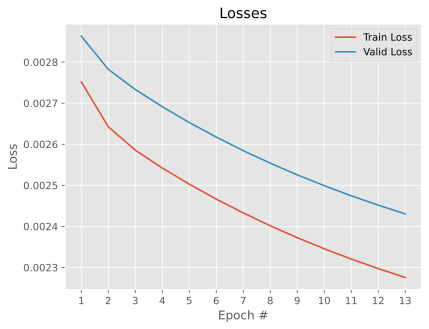

In [30]:
epoch_ticks = range(1, n_epochs + 1)
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

### Check Performance of BoW Model

In [31]:
bow_model.eval()
test_accuracy, n_examples = 0, 0
y_true, y_pred = [], []
input_type = 'bow'

with torch.no_grad():
    for seq, bow, tfidf, target, text in test_loader:
        inputs = bow
        probs = bow_model(inputs)

        probs = probs.detach().cpu().numpy()
        predictions = np.argmax(probs, axis=1)
        target = target.cpu().numpy()

        y_true.extend(predictions)
        y_pred.extend(target)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.79      0.78      1556
           1       0.79      0.77      0.78      1551

    accuracy                           0.78      3107
   macro avg       0.78      0.78      0.78      3107
weighted avg       0.78      0.78      0.78      3107



**Let's check a few examples**

In [32]:
flatten = lambda x: [sublst for lst in x for sublst in lst]
seq_lst, bow_lst, tfidf_lst, target_lst, text_lst = zip(*test_loader)
seq_lst, bow_lst, tfidf_lst, target_lst, text_lst = map(flatten, [seq_lst, bow_lst, tfidf_lst, target_lst, text_lst])
test_examples = list(zip(seq_lst, bow_lst, tfidf_lst, target_lst, text_lst))

def print_random_prediction(model, n=5, input_type='bow'):
    to_emoji = lambda x: '😄' if x else '😡'
    model.eval()
    rows = []
    for i in range(n):
        with torch.no_grad():
            seq, bow, tdidf, target, text = random.choice(test_examples)
            target = target.item()

            inputs = bow
            if input_type == 'tdidf':
                inputs = tfidf

            probs = model([inputs])
            probs = probs.detach().cpu().numpy()
            prediction = np.argmax(probs, axis=1)[0]

            predicted = to_emoji(prediction)
            actual = to_emoji(target)

            row = f"""
            <tr>
            <td>{i+1}&nbsp;</td>
            <td>{text}&nbsp;</td>
            <td>{predicted}&nbsp;</td>
            <td>{actual}&nbsp;</td>
            </tr>
            """
            rows.append(row)

    rows_joined = '\n'.join(rows)
    table = f"""
    <table>
    <tbody>
    <tr>
    <td><b>Number</b>&nbsp;</td>
    <td><b>Review</b>&nbsp;</td>
    <td><b>Predicted</b>&nbsp;</td>
    <td><b>Actual</b>&nbsp;</td>
    </tr>{rows_joined}
    </tbody>
    </table>
    """
    display(HTML(table))

In [33]:
print_random_prediction(bow_model, n=5, input_type='bow')

Number,Review,Predicted,Actual
1,"This film should have been only 10 minutes. I mean there is really only 10 minute worth of watchable content in this thing (I even hesitate to call it a movie). The opening credits of the film was somehow promising. As the film begins by short comments of the man himself, you really rub your hands and stay tuned for more footage from Cohen's life. Well, Nick Cave does a reasonable job covering one of Cohen's famous songs. The length of Cave's performance makes you even more eager to see more of Cohen whose wit and well spoken words have already tickled your fancy. But as it turns out Cave's performance is only the start of lengthy super boring performances by literally a bunch of no ones who don't even have a minimal attraction to keep you on your seat. I mean what does the filmmaker really think? five-minute close-up shots of wanna be singers in a fake concert in Australia!!! What does the filmmaker really think to insult the audience by adding \fake applause\"" to these endless nasty performances. The film is a perfect torture that shows you very little of what you came to see. There is not a single footage of Cohen's past. In fact, except for a few photographs of his early days as a singer/poet there is absolutely nothing! If you add up all the minutes that Cohen talks it may not even reach 10 minutes. But these 10 minutes are tortuously presented bit by bit in between disastrous camera-work that captures some of the most unattractive people screaming Cohen's lyrics. If you ever decided to waste your money on this film, DON'T! just throw it in the garbage and at least save your time.""",😡,😡
2,"This move is about as bad as they come. I was, however forced to give it a 2 for the scenery. There are many great shots of the southwest including many in Monument Valley, one of the most breathtaking places in the US. It is also, starting with John Ford, one of the most filmed. In fact one scene with Kris and the girl was filmed on a place called John Ford point.",😄,😡
3,"The Intruder (L'Intrus), a film directed by French director Clair Denis, is the liberation of film. It follows its own spirit across time, space, and character. There may be a plot, but what I understood of that I picked up from the description on the Netflix DVD sleeve. Honestly, it's probably better to know nothing about the film before watching it, because then the viewer can set aside any and all expectations. The film demands that the viewer think, but also taunts the fact that he or she will not gain full understanding.The human heart is the film's enigma. Every image questions its role, its nature, and its form. The heart is the intruder, that of the viewer and that of Louis. Louis' character is played by Michel Subor with the peace and mystery required by such a character. Honestly, anyone could've played Louis' character, if he or she possessed a wandering, willing, and comfortable heart. Yet Subor is the one featured here; he becomes the film, his identity is inseparable from it. Many of the film's images lingering in my mind revolve around his expressions, vocal but mainly physical.The Intruder is poetic in its ability to capture the stillness and fullness of movement, but more fluid than any literature in the shape it refuses to take. \Surrealistic\"" has been a term used in describing this film, but perhaps \""quasirealistic\"" is a more adequate term. Nothing in the film exists outside of the possibilities of reality; the simple omnipresent score confirms that by imagining in music the connection between heartbeat and dim light.Watch the trailer a few times if you're attracted to visual imagery; see the film to see the consequences of the combination of verse and a grasping for freedom.""",😄,😄
4,"I've never given a movie a ten out of ten before but this is the closest I have ever come (I gave it a 9). There are very few movies that I truly love, this however is one of them. With it's gritty realism, fantastic on-site l

## TF-IDF Model

**Term Frequency - Inverse Document Frequency**

For a term `i` in document `j`:

$$TFIDF = TF_{i,j} \times log \frac{N}{DF_i}$$

- TF: number of occurance of the term `i` in document `j`
- N: total number of documents
- DF: number of documents containins the term `i`

Questions:
- Why would this be more representative than pure bag of words?
- What does TFIDF score of a word mean for a document?

### Initialize TF-IDF Model

In [34]:
tfidf_model = LinearTextClassifier(
    vocab_size=len(dataset.token2idx),
    num_labels=2,
)
tfidf_model

LinearTextClassifier(
  (fc): Linear(in_features=990, out_features=2, bias=True)
)

### Train TF-IDF Model

TF-IDF vectors as input

In [35]:
LEARNING_RATE = 5e-5

In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, tfidf_model.parameters()),
    lr=LEARNING_RATE,
)
scheduler = CosineAnnealingLR(optimizer, 1)

In [37]:
n_epochs = 0
train_losses, valid_losses = [], []
while True:
    train_loss = train_epoch(tfidf_model, optimizer, train_loader, input_type='tfidf')
    valid_loss = validate_epoch(tfidf_model, valid_loader, input_type='tfidf')

    tqdm.write(
        f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.2e}\tvalid_loss: {valid_loss:.2e}\n',
    )

    # Early stopping if the current valid_loss is greater than the last three valid losses
    if len(valid_losses) > 2 and all(valid_loss >= loss for loss in valid_losses[-3:]):
        print('Stopping early')
        break

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    n_epochs += 1

epoch #  1	train_loss: 2.71e-03	valid_loss: 2.90e-03

epoch #  2	train_loss: 2.71e-03	valid_loss: 2.89e-03

epoch #  3	train_loss: 2.70e-03	valid_loss: 2.88e-03

epoch #  4	train_loss: 2.70e-03	valid_loss: 2.88e-03

epoch #  5	train_loss: 2.69e-03	valid_loss: 2.87e-03

epoch #  6	train_loss: 2.69e-03	valid_loss: 2.87e-03

epoch #  7	train_loss: 2.68e-03	valid_loss: 2.86e-03

epoch #  8	train_loss: 2.68e-03	valid_loss: 2.86e-03

epoch #  9	train_loss: 2.67e-03	valid_loss: 2.85e-03

epoch # 10	train_loss: 2.67e-03	valid_loss: 2.85e-03

epoch # 11	train_loss: 2.66e-03	valid_loss: 2.85e-03

epoch # 12	train_loss: 2.66e-03	valid_loss: 2.84e-03

epoch # 13	train_loss: 2.65e-03	valid_loss: 2.84e-03

epoch # 14	train_loss: 2.65e-03	valid_loss: 2.83e-03

epoch # 15	train_loss: 2.64e-03	valid_loss: 2.83e-03

epoch # 16	train_loss: 2.64e-03	valid_loss: 2.82e-03

epoch # 17	train_loss: 2.64e-03	valid_loss: 2.82e-03

epoch # 18	train_loss: 2.63e-03	valid_loss: 2.81e-03

epoch # 19	train_loss: 2.63e

KeyboardInterrupt: 

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


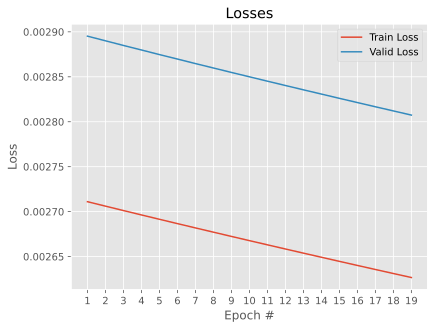

In [39]:
epoch_ticks = range(1, n_epochs + 1)
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

### TF-IDF Performance

In [40]:
tfidf_model.eval()
test_accuracy, n_examples = 0, 0
y_true, y_pred = [], []

with torch.no_grad():
    for seq, bow, tfidf, target, text in test_loader:
        inputs = tfidf
        probs = tfidf_model(inputs)

        probs = probs.detach().cpu().numpy()
        predictions = np.argmax(probs, axis=1)
        target = target.cpu().numpy()

        y_true.extend(predictions)
        y_pred.extend(target)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.76      0.79      1729
           1       0.73      0.81      0.76      1378

    accuracy                           0.78      3107
   macro avg       0.78      0.78      0.78      3107
weighted avg       0.78      0.78      0.78      3107



In [41]:
print_random_prediction(tfidf_model, n=5, input_type='tfidf')

Number,Review,Predicted,Actual
1,"I probably doubled my knowledge of Iran when I saw Secret Ballot (2001). Now I know about four times as much (I doubt I learned a whole heck of a lot from Not Without My Daughter (1991)).Offside is a splendid budget Iranian comedy about a group a girls (working individually) to attend a decisive soccer match for their country's place in the World Cup. Women are not allowed to attend soccer matches, so the nation's armed forces have been mobilized to save any women who try to enter from themselves. Some (teen?) girls try to crash the party by dressing as boys, but are caught. The movie is mostly set at this holding pen where the girls are detained by soldiers, awaiting some unspecified punishment (although, the girl who dressed as a soldier claims that she was one insignia away from being executed!)The movie explores the absurdity of the situation. The thinking that bars women from football matches comes down to it being too raunchy an experience for the fairer sexÂ?a philosophy not unknown in the west less than 100 years ago. This farce comes to a head when a girl needs to go to the bathroom, so a soldier escorting her demands that she cover her eyes so she can't see the graffiti. The conflict is not entirely about the battle of the sexes: at one point some friction arises between a solider who is rural and the girls who are urban.Fortunately, this movie was not too culturally esoteric that the comedy was lost on this neighbour and cultural cousin of the Great Satan. You have to be in the mood for it, but no one should avoid this movie because they think that they won't get it.",😄,😄
2,"Okay first of all, I didn't sit down to watch the premier of a ""Star Trek"" Series to see a cowboy flying around in space. this is how a normal Enterprise episode works1 Archer finds a nebula or something aloung the lines of that and wants to take a closer look but it might destroy the ship.2 he sends a shuttle into the nebula and and the shuttle get damaged...in all of the episodes I have seen, all of the problems are happening because of Archer's stupid mistakes. Oh and did you see the preview of one episode showing Archer and T'pol kissing?!?!?!?!?!?!? I was planning to watch that episode but after that I totally gave up on Enterprise and turned to TV right off. Come on!!!! This is star trek!!!!!!!!!!!!!!!!!!!!Also what was with the banana slug?? In one episode, Hoshi had a banana slug but had to leave it behind for some stupid reason. Okay fine, little dumb to bring you pet slug in space but whatever. Okay that was what I thought until they left it on a desert planet!!!!! A BANANA SLUG CANNOT LEAVE IN A DESERT!!!!!!!!!!!! How dumb are these writersAny ways, just saying if Enterprise is on DON'T WATCH IT!!!!!",😡,😡
3,"Another variation and improvisation on the famous and beloved children tale, La Bete (1975) aka The Beast tries to imagine (in very graphic and what may seem offensive and disturbing but in reality rather silly and comical way), what actually happened between Beauty and the Beast? I am amused by many reviews and comments that seem to look too deeply into this movie. I would not go so far as saying that it is a serious and dark exploration of such subjects as sexual frustration, longing, fulfillment, or satirical criticizing of the catholic Religion. I would not even call it a horror-erotic movie. It's more of the parody on all genres it touches or mentions even though it's got some shocking moments in all departments that sure will stay in your memory.The long (way too long) scene between an Aristocratic young woman and the supposedly horrifying but the most laughable I've ever seen in the movies creature with truly impressive...well anatomy, is set to the clavichord music of Scarlatti and is hysterical. My husband and I both laughed out loud at the exaggerated details of the encounter. The moral of the scene is - beauty can and will defeat the monster. The question is - who is the target audien

## Quiz 1: Build your own Neural Logistic Regression Text Classifier


- Input: BoW vector or TF-IDF vector
- 2 Affine layer (what are the dimensions of input and output?)
- 1 Softmax activation

In [60]:
# Define hidden layer size
HIDDEN1 = 180 ## @param ["10","30","50","100","200","500"] {"type":"raw","allow-input":true}
HIDDEN2 = 100 ##@param [10, 30, 50, 100, 200, 500] {allow-input: true}

In [61]:
## define your feedforward neural networks:
class FeedfowardTextClassifier(nn.Module):
    def __init__(self, vocab_size, HIDDEN1,HIDDEN2, num_labels, dropout_pub=0.3): # pass layer dimension
        ## add layers
        super(FeedfowardTextClassifier, self).__init__()
        self.fc1=  nn.Linear(vocab_size,HIDDEN1)
        self.fc2=  nn.Linear(HIDDEN1,HIDDEN2)
        self.fc3=  nn.Linear(HIDDEN2,num_labels)
        self.dropout = nn.Dropout(dropout_pub)

    def forward(self, x):
        x = torch.FloatTensor(x).to(device)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))



        return x




        ## pass through affine layer & activation

In [62]:

neural_model = FeedfowardTextClassifier(
    vocab_size = len(dataset.token2idx),
    HIDDEN1 = 180,
    HIDDEN2 = 90,
    num_labels = 2,
    dropout_pub = 0.3,
)
neural_model

FeedfowardTextClassifier(
  (fc1): Linear(in_features=990, out_features=180, bias=True)
  (fc2): Linear(in_features=180, out_features=90, bias=True)
  (fc3): Linear(in_features=90, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [63]:
LEARNING_RATE = 3e-3
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, neural_model.parameters()),
    lr=LEARNING_RATE, #try add weight_decay
    weight_decay=1e-5,
)
scheduler = CosineAnnealingLR(optimizer, 1)

In [64]:
## Run training & validation
n_epochs = 0
train_loss = 0
valid_loss = 0

train_losses, valid_losses = [], []
while True:
    train_loss = train_epoch(neural_model, optimizer, train_loader, input_type='tfidf')
    valid_loss = validate_epoch(neural_model, valid_loader, input_type='tfidf')

    tqdm.write(
        f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.2e}\tvalid_loss: {valid_loss:.2e}\n',
    )

    # Early stopping if the current valid_loss is greater than the last three valid losses
    if len(valid_losses) > 2 and all(valid_loss >= loss for loss in valid_losses[-3:]):
        print('Stopping early')
        break

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    n_epochs += 1

epoch #  1	train_loss: 1.59e-03	valid_loss: 1.45e-03

epoch #  2	train_loss: 1.31e-03	valid_loss: 1.40e-03

epoch #  3	train_loss: 1.24e-03	valid_loss: 1.39e-03

epoch #  4	train_loss: 1.18e-03	valid_loss: 1.37e-03

epoch #  5	train_loss: 1.09e-03	valid_loss: 1.37e-03

epoch #  6	train_loss: 9.68e-04	valid_loss: 1.34e-03

epoch #  7	train_loss: 8.19e-04	valid_loss: 1.36e-03

epoch #  8	train_loss: 6.79e-04	valid_loss: 1.28e-03

epoch #  9	train_loss: 5.61e-04	valid_loss: 1.33e-03

epoch # 10	train_loss: 4.66e-04	valid_loss: 1.41e-03

Stopping early


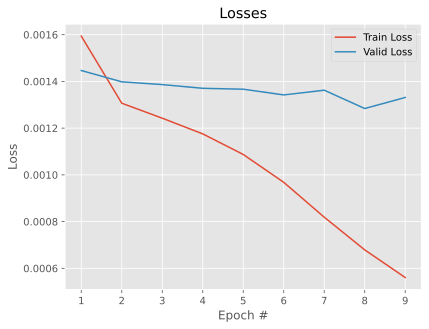

In [65]:
epoch_ticks = range(1, n_epochs + 1)
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

In [67]:
neural_model.eval()
test_accuracy, n_examples = 0, 0
y_true, y_pred = [], []

with torch.no_grad():
    for seq, bow, tfidf, target, text in test_loader:
        inputs = tfidf
        probs = neural_model(inputs)

        probs = probs.detach().cpu().numpy()
        predictions = np.argmax(probs, axis=1)
        target = target.cpu().numpy()

        y_true.extend(predictions)
        y_pred.extend(target)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1413
           1       0.93      0.84      0.88      1694

    accuracy                           0.88      3107
   macro avg       0.88      0.88      0.88      3107
weighted avg       0.88      0.88      0.88      3107



In [68]:
print_random_prediction(neural_model, n=5, input_type='tfidf')

Number,Review,Predicted,Actual
1,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. This being a variation on the Arthur Schnitzler's play about the same theme, the director transfers the action to the present time New York where all these different characters meet and connect. Each one is connected in one way, or another to the next person, but no one seems to know the previous point of contact. Stylishly, the film has a sophisticated luxurious look. We are taken to see how these people live and the world they live in their own habitat.The only thing one gets out of all these souls in the picture is the different stages of loneliness each one inhabits. A big city is not exactly the best place in which human relations find sincere fulfillment, as one discerns is the case with most of the people we encounter.The acting is good under Mr. Mattei's direction. Steve Buscemi, Rosario Dawson, Carol Kane, Michael Imperioli, Adrian Grenier, and the rest of the talented cast, make these characters come alive.We wish Mr. Mattei good luck and await anxiously for his next work.",😄,😄
2,"Please! Do not waste any money on this movie. It really is nothing more than a boring German Blair Witch ripoff made by some high school kids. I couldn't finish watching it, and usually I like watching all kinds of B-movies. How on earth could they find a distributor for it?!!! Funny however: Check out Wikipedia for ""dark area"". The guy who wrote the entry must be completely out of his mind. Maybe he got loads of money from the producers. Money that should have been spend on actors, camera and editing. Even that wouldn't have helped, since there is absolutely no interesting idea behind this film. Unfortunately ""dark area"" has already gotten too much attention. Please, director, producer and author of this movie, STOP making movies like that...you are not doing yourself a favor. The world would be a better place without this film.",😡,😡
3,"This is a quite slow paced movie, slowly building the story of an ex stripper who begins a new family life with a complete stranger. The viewer slowly feels that there's something wrong here ...I really loved this movie even though it leaves a slight bitter taste in the end. It is clever, well paced and very well acted. Both Philippe Toretton and Emmannuelle Seigner are deeply into their characters. The little son ""pierrot"" is also very touching.A thriller which does not seem like one. A very unconventional movie, very particular atmosphere throughout the whole movie though you might feel awkward a few times with a couple of scenes.i'll give it a 8/10 !!",😄,😄
4,"It's a little disconcerting to have a character named Gig Young in a movie...played by Gig Young. But this film is where Gig got his name and also a nice career boost after playing small parts under another name.I'm going to go against the majority of the other comments and state that I really enjoyed this film, mainly because of the vibrant performance of Barbara Stanwyck as Fiona. She was funny, angry, vulnerable, caring, and feisty as the oldest of three daughters whose mother died on the Lusitania, and whose father was later killed during Woar War I. As the ""man"" of the house, Fiona has stood steadfast for years against settling her father's will which would therefore allow a Donald Trump type named Charles Barclay to get the family home. But Fiona's keeping a secret as to why she hates Barclay so much. Geraldine Fitzgerald is the middle, flirty sister, who is married to an Englishman but craves her youngest sister's boyfriend (Gig Young).If you're a Stanwyck fan, this is a no miss.",😄,😄
5,"This is one of those unique horror films that requires a much more mature understanding of the word 'horror' in order for it to be appreciated. The

# Quiz 2: BoW Naive Bayes
If the feature vectors are binary indicator, is it true that all naive Bayes classifier can be represented by another feature based linear classifier?

More formally, for $\phi(x)\in \{0,1\}^d$ and a dataset D=$\{(x_i,y_i)\}_{i=1}^n$. Can we get a set of linear scores $\{\theta_y \}_y$ and a feature vector $\phi'$ such that $\hat{P}_{naive\_bayes}(y|x)= \frac{\exp (\langle \theta_y,\phi'(x)\rangle)}{\sum_{y'} \exp (\langle \theta_{y'},\phi'(x)\rangle)}$ ?

Recall that $\hat{P}_{naive\_bayes}(y|x)= \frac{\hat{P}_{mle}(y)\hat{P}_{mle}(x|y)}{\sum_{y'} \hat{P}_{mle}(y)\hat{P}_{mle}(x|y)}$ where the estimator is from the dataset.